# Import packages

In [2]:
import warnings

import pandas as pd

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

import scanpy as sc
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import pertpy as pt
from collections import Counter
import scvi

2024-07-18 15:47:15.878945: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-18 15:47:16.394069: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Load dataset

In [10]:
adata = sc.read(
    filename="data/fede_count_clustered.h5ad"
)

# Compositional analysis

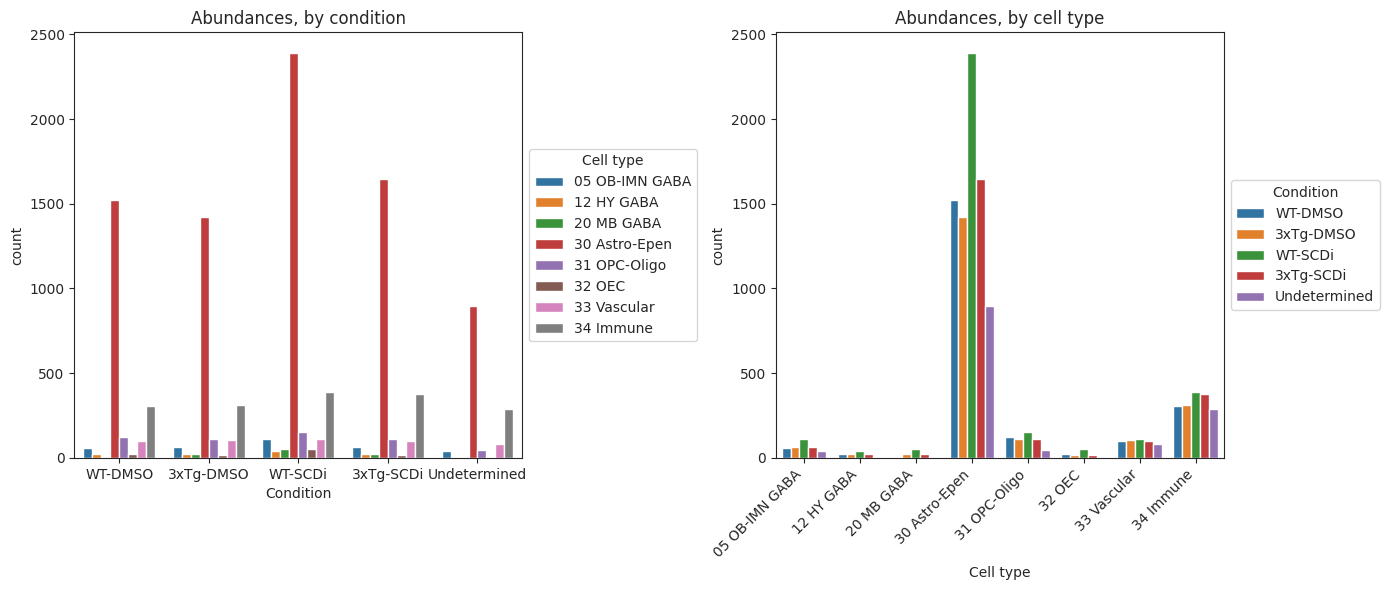

In [11]:
# Assuming 'adata.obs' is your DataFrame
df = adata.obs[['total_counts', 'Sample_Tag', 'class_name']]

# Aggregate the data to get the number of cells per cell type
cell_type_counts = df['class_name'].value_counts()

# Filter out cell types with less than 100 cells
filtered_cell_types = cell_type_counts[cell_type_counts >= 100].index

# Filter the original DataFrame
filtered_df = df[df['class_name'].isin(filtered_cell_types)]

# Pivot the DataFrame to get the number of cells instead of total counts
pivot_df = filtered_df.groupby(['Sample_Tag', 'class_name']).size().unstack(fill_value=0)

# Resetting the index
pivot_df.reset_index(inplace=True)

# Melting the DataFrame to long format
plot_data_global = pivot_df.melt(id_vars="Sample_Tag", var_name="Cell type", value_name="count")

# Renaming 'Sample_Tag' to 'Condition' to match the plot example
plot_data_global.rename(columns={'Sample_Tag': 'Condition'}, inplace=True)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Filtered DataFrame for plotting to ensure legends and data match
filtered_plot_data_global = plot_data_global[
    plot_data_global['Cell type'].isin(filtered_cell_types)
]

# Plot for Global abundances, by condition
sns.barplot(
    data=filtered_plot_data_global, x="Condition", y="count", hue="Cell type", ax=ax[0]
)
ax[0].set_title("Abundances, by condition")
ax[0].legend(title="Cell type", loc='center left', bbox_to_anchor=(1, 0.5))

# Plot for Global abundances, by cell type
sns.barplot(
    data=filtered_plot_data_global, x="Cell type", y="count", hue="Condition", ax=ax[1]
)
ax[1].set_title("Abundances, by cell type")
ax[1].legend(title="Condition", loc='center left', bbox_to_anchor=(1, 0.5))

# Rotate the x-axis labels of the right plot
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [12]:
class_counts = adata.obs['class_name'].value_counts()
valid_classes = class_counts[class_counts >= 100].index
filtered_adata = adata[adata.obs['class_name'].isin(valid_classes)].copy()

In [6]:
filtered_adata.obs['index'] = filtered_adata.obs.index

In [13]:
milo = pt.tl.Milo()
mdata = milo.load(adata)

MuData object with n_obs × n_vars = 12031 × 25244
  2 modalities
    rna:	12031 x 25244
      obs:	'Sample_Tag', 'Sample_Name', 'SampleTag01_flex_Read_Count', 'SampleTag02_flex_Read_Count', 'SampleTag03_flex_Read_Count', 'SampleTag04_flex_Read_Count', 'SampleTag05_flex_Read_Count', 'SampleTag06_flex_Read_Count', 'SampleTag07_flex_Read_Count', 'SampleTag08_flex_Read_Count', 'SampleTag09_flex_Read_Count', 'SampleTag10_flex_Read_Count', 'SampleTag11_flex_Read_Count', 'SampleTag12_flex_Read_Count', 'SampleTag13_flex_Read_Count', 'SampleTag14_flex_Read_Count', 'SampleTag15_flex_Read_Count', 'SampleTag16_flex_Read_Count', 'SampleTag17_flex_Read_Count', 'SampleTag18_flex_Read_Count', 'SampleTag19_flex_Read_Count', 'SampleTag20_flex_Read_Count', 'SampleTag21_flex_Read_Count', 'SampleTag22_flex_Read_Count', 'SampleTag23_flex_Read_Count', 'SampleTag24_flex_Read_Count', 'class_name', 'subclass_name', 'supertype_name', 'cluster_name', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'high_mt', 'n_genes', 'leiden', 'cluster_class_name', 'cluster_subclass_name', 'cluster_supertype_name'
      var:	'Raw_Reads', 'Raw_Molecules', 'Raw_Seq_Depth', 'RSEC_Adjusted_Molecules', 'RSEC_Adjusted_Reads_non-singleton', 'RSEC_Adjusted_Molecules_non-singleton', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_deviant', 'binomial_deviance', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'Pipeline_Inputs', 'Pipeline_Metrics', 'Sample_Tag_colors', 'cluster_subclass_name_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_tsne', 'X_umap'
      varm:	'PCs'
      layers:	'counts', 'log1p_norm'
      obsp:	'connectivities', 'distances'
    milo:	0 x 0

In [17]:
adata.layers["counts"] = adata.X.copy()
adata.layers["logcounts"] = sc.pp.log1p(adata.layers["counts"]).copy()
adata.X = adata.layers["logcounts"].copy()

sc.pp.highly_variable_genes(
    adata, n_top_genes=3000, subset=False
)

sc.pp.pca(adata, n_comps=10)
sc.pp.neighbors(adata, n_pcs=10)
sc.tl.umap(adata)

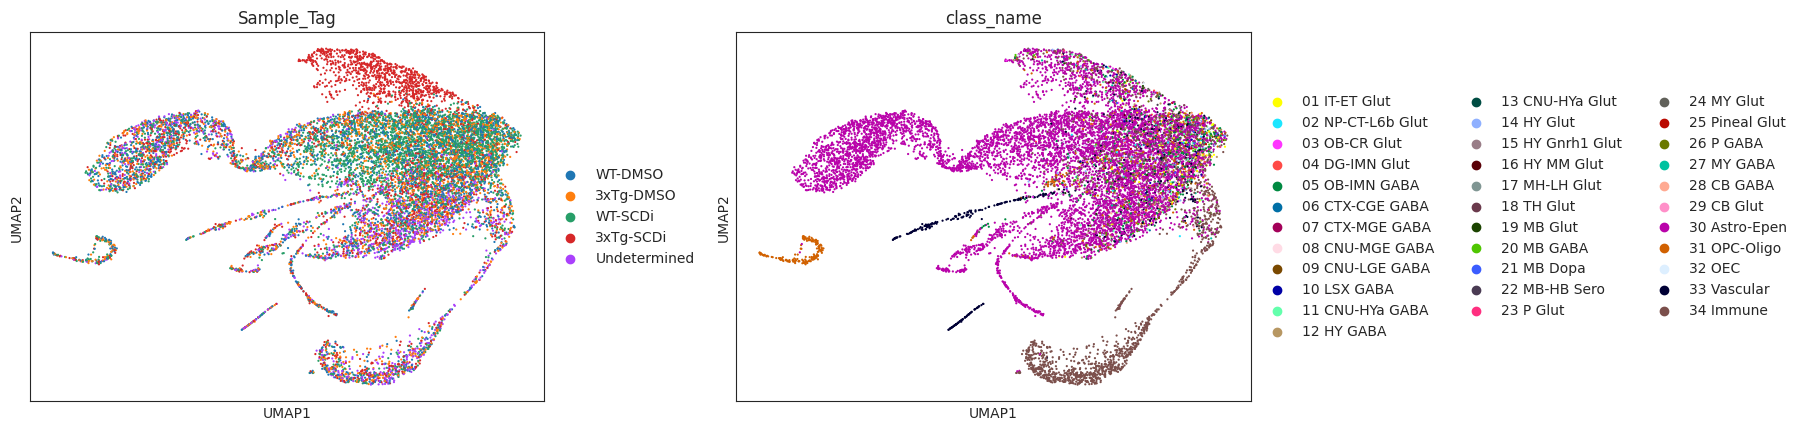

In [18]:
sc.pl.umap(adata, color=["Sample_Tag", "class_name"], ncols=3, wspace=0.25)

In [21]:
adata_scvi = adata[:, adata.var["highly_variable"]].copy()
scvi.model.SCVI.setup_anndata(adata_scvi, layer="counts", batch_key="Sample_Tag")
model_scvi = scvi.model.SCVI(adata_scvi)
max_epochs_scvi = int(np.min([round((20000 / adata.n_obs) * 400), 400]))
model_scvi.train(max_epochs=max_epochs_scvi)
adata.obsm["X_scVI"] = model_scvi.get_latent_representation()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|█| 400/400 [02:53<00:00,  2.32it/s, v_num=1, train_loss_step

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█| 400/400 [02:53<00:00,  2.31it/s, v_num=1, train_loss_step


In [22]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)

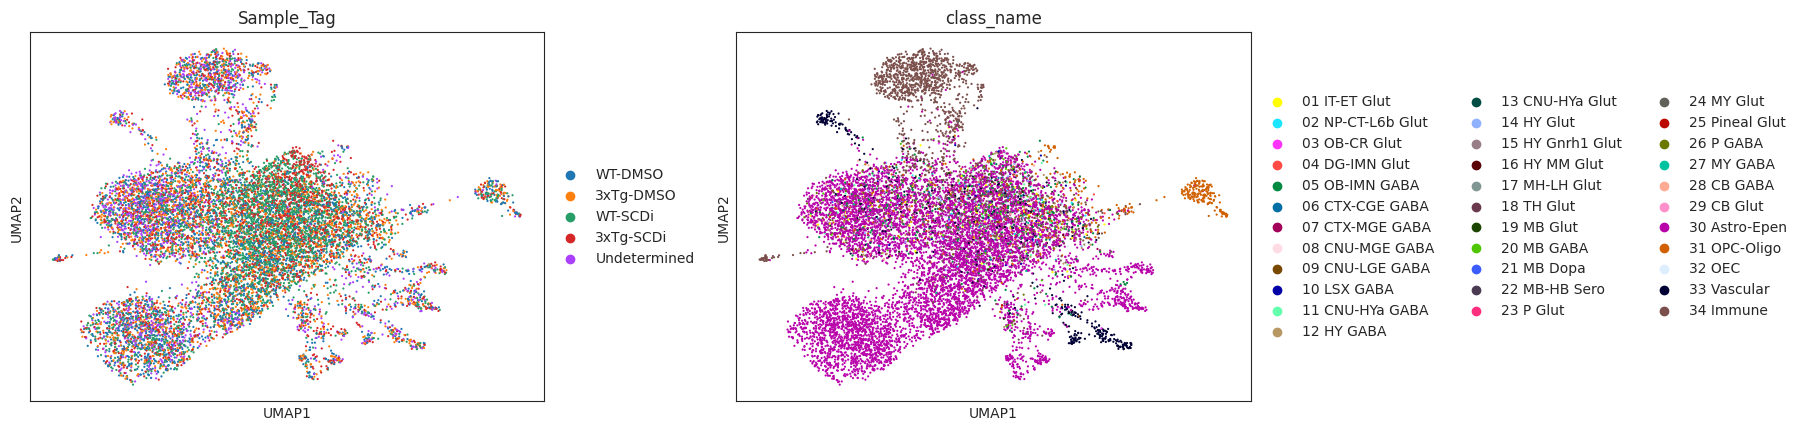

In [23]:
sc.pl.umap(adata, color=["Sample_Tag", "class_name"], ncols=3, wspace=0.25)

In [24]:
milo.make_nhoods(mdata, prop=0.1)

In [25]:
adata.obsm["nhoods"]

<12031x1050 sparse matrix of type '<class 'numpy.float32'>'
	with 29235 stored elements in Compressed Sparse Row format>

Text(0, 0.5, '# neighbouthoods')

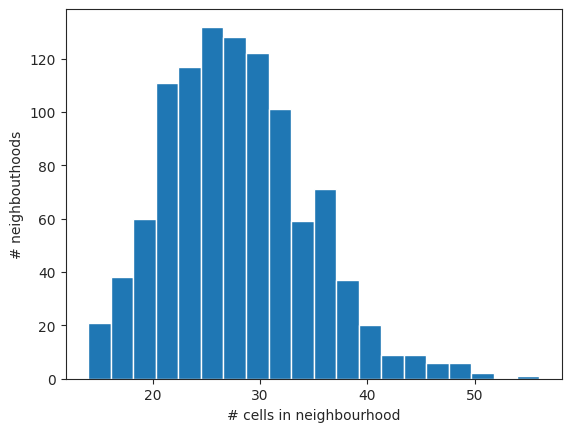

In [26]:
nhood_size = adata.obsm["nhoods"].toarray().sum(0)
plt.hist(nhood_size, bins=20)
plt.xlabel("# cells in neighbourhood")
plt.ylabel("# neighbouthoods")

In [27]:
sc.pp.neighbors(adata, n_neighbors=30, use_rep="X_scVI", key_added="milo")
milo.make_nhoods(mdata, neighbors_key="milo", prop=0.1)

Text(0, 0.5, '# neighbouthoods')

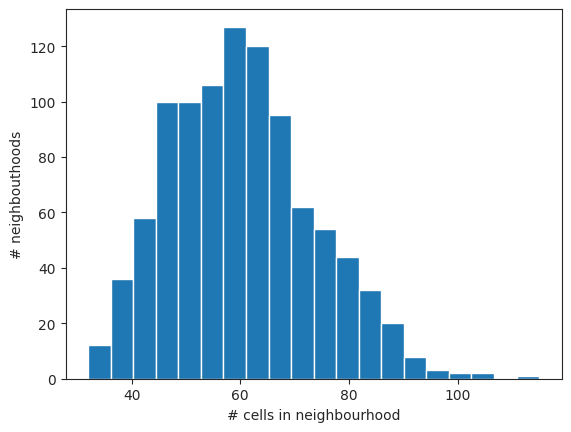

In [28]:
nhood_size = adata.obsm["nhoods"].toarray().sum(0)
plt.hist(nhood_size, bins=20)
plt.xlabel("# cells in neighbourhood")
plt.ylabel("# neighbouthoods")

In [32]:
milo.count_nhoods(mdata, sample_col="Sample_Tag")

MuData object with n_obs × n_vars = 12031 × 25244
  2 modalities
    rna:	12031 x 25244
      obs:	'Sample_Tag', 'Sample_Name', 'SampleTag01_flex_Read_Count', 'SampleTag02_flex_Read_Count', 'SampleTag03_flex_Read_Count', 'SampleTag04_flex_Read_Count', 'SampleTag05_flex_Read_Count', 'SampleTag06_flex_Read_Count', 'SampleTag07_flex_Read_Count', 'SampleTag08_flex_Read_Count', 'SampleTag09_flex_Read_Count', 'SampleTag10_flex_Read_Count', 'SampleTag11_flex_Read_Count', 'SampleTag12_flex_Read_Count', 'SampleTag13_flex_Read_Count', 'SampleTag14_flex_Read_Count', 'SampleTag15_flex_Read_Count', 'SampleTag16_flex_Read_Count', 'SampleTag17_flex_Read_Count', 'SampleTag18_flex_Read_Count', 'SampleTag19_flex_Read_Count', 'SampleTag20_flex_Read_Count', 'SampleTag21_flex_Read_Count', 'SampleTag22_flex_Read_Count', 'SampleTag23_flex_Read_Count', 'SampleTag24_flex_Read_Count', 'class_name', 'subclass_name', 'supertype_name', 'cluster_name', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'high_mt', 'n_genes', 'leiden', 'cluster_class_name', 'cluster_subclass_name', 'cluster_supertype_name', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
      var:	'Raw_Reads', 'Raw_Molecules', 'Raw_Seq_Depth', 'RSEC_Adjusted_Molecules', 'RSEC_Adjusted_Reads_non-singleton', 'RSEC_Adjusted_Molecules_non-singleton', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_deviant', 'binomial_deviance', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'Pipeline_Inputs', 'Pipeline_Metrics', 'Sample_Tag_colors', 'cluster_subclass_name_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap', 'class_name_colors', 'nhood_neighbors_key', 'milo'
      obsm:	'X_pca', 'X_tsne', 'X_umap', 'X_scVI', 'nhoods'
      varm:	'PCs'
      layers:	'counts', 'log1p_norm', 'logcounts'
      obsp:	'connectivities', 'distances', 'milo_distances', 'milo_connectivities'
    milo:	5 x 982
      var:	'index_cell', 'kth_distance'
      uns:	'sample_col'

Text(0, 0.5, 'Mean # cells per sample in nhood')

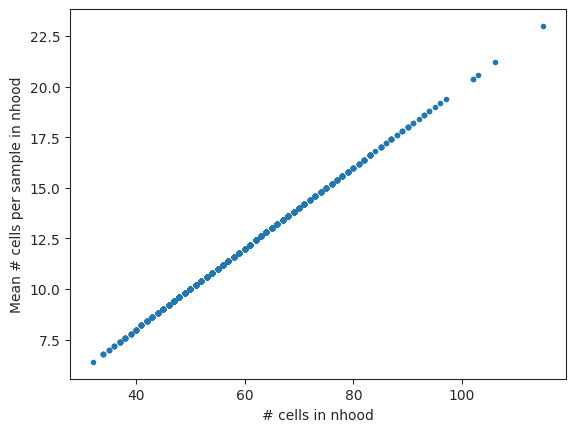

In [34]:
mean_n_cells = mdata["milo"].X.toarray().mean(0)
plt.plot(nhood_size, mean_n_cells, ".")
plt.xlabel("# cells in nhood")
plt.ylabel("Mean # cells per sample in nhood")

In [86]:
milo.da_nhoods(
    mdata, design="~condition", model_contrasts="conditionSalmonella-conditionControl"
)
milo_results_salmonella = mdata["milo"].obs.copy()

Covariates condition are not columns in adata.obs

KeyError: "['condition'] not in index"

KeyError: 'PValue'

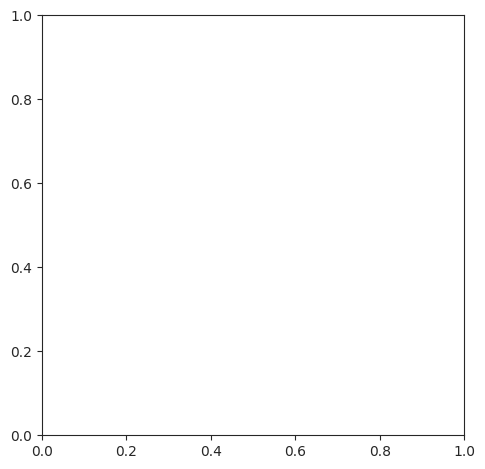

In [49]:
def plot_milo_diagnostics(mdata):
    alpha = 0.1  ## significance threshold

    with matplotlib.rc_context({"figure.figsize": [12, 12]}):

        ## Check P-value histogram
        plt.subplot(2, 2, 1)
        plt.hist(mdata["milo"].var["PValue"], bins=20)
        plt.xlabel("Uncorrected P-value")

        ## Visualize extent of multiple-testing correction
        plt.subplot(2, 2, 2)
        plt.scatter(
            mdata["milo"].var["PValue"],
            mdata["milo"].var["SpatialFDR"],
            s=3,
        )
        plt.xlabel("Uncorrected P-value")
        plt.ylabel("SpatialFDR")

        ## Visualize volcano plot
        plt.subplot(2, 2, 3)
        plt.scatter(
            mdata["milo"].var["logFC"],
            -np.log10(mdata["milo"].var["SpatialFDR"]),
            s=3,
        )
        plt.axhline(
            y=-np.log10(alpha),
            color="red",
            linewidth=1,
            label=f"{int(alpha*100)} % SpatialFDR",
        )
        plt.legend()
        plt.xlabel("log-Fold Change")
        plt.ylabel("- log10(SpatialFDR)")
        plt.tight_layout()

        ## Visualize MA plot
        df = mdata["milo"].var
        emp_null = df[df["SpatialFDR"] >= alpha]["logFC"].mean()
        df["Sig"] = df["SpatialFDR"] < alpha

        plt.subplot(2, 2, 4)
        sns.scatterplot(data=df, x="logCPM", y="logFC", hue="Sig")
        plt.axhline(y=0, color="grey", linewidth=1)
        plt.axhline(y=emp_null, color="purple", linewidth=1)
        plt.legend(title=f"< {int(alpha*100)} % SpatialFDR")
        plt.xlabel("Mean log-counts")
        plt.ylabel("log-Fold Change")
        plt.show()


plot_milo_diagnostics(mdata)

In [55]:
milo.build_nhood_graph(mdata)
with matplotlib.rc_context({"figure.figsize": [10, 10]}):
    pt.pl.milo.nhood_graph(mdata, alpha=0.1, min_size=5, plot_edges=False)
    sc.pl.umap(mdata["rna"], color="cell_label", legend_loc="on data")

TypeError: Milo.plot_nhood_graph() missing 1 required positional argument: 'mdata'

In [ ]:
milo.annotate_nhoods(mdata, anno_col="cell_label")
# Define as mixed if fraction of cells in nhood with same label is lower than 0.75

mdata["milo"].var.loc[
    mdata["milo"].var["nhood_annotation_frac"] < 0.75, "nhood_annotation"
] = "Mixed"

In [ ]:
pt.pl.milo.da_beeswarm(mdata)
plt.show()